In [1]:
import numpy as np
import pandas as pd 
import scipy
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()
import thinkstats2
import thinkplot

pd.options.display.float_format = '{:.2f}'.format # change the display format of numbers

In [2]:
saffronart_df = pd.read_csv('updated_saffronart_dataset.csv') 

# change the dates to Pandas datetime objects:
saffronart_df['auction_date'] = pd.to_datetime(saffronart_df['auction_date'])
saffronart_df['birth_date'] = pd.to_datetime(saffronart_df['birth_date'])
saffronart_df['death_date'] = pd.to_datetime(saffronart_df['death_date'])

saffronart_df.head(5)

,artist,birth_date,birth_place,death_date,artist_age,title,winning_bid,low_est,high_est,auction_date,category,style,size,medium,area_or_vol,auction_dt_age
0,akhilesh,1956-01-01,Indore,NaT,63.00,Divine Conversation,9000.00,5000.00,7000.00,2019-06-01,painting,abstract,71.5 x 71.5 in,acrylic on canvas,5112.25,63.00
1,akhilesh,1956-01-01,Indore,NaT,63.00,In search of Untitled forms -II,1120.00,5000.00,6670.00,2013-11-01,painting,abstract,32.5 x 44 in,acrylic on canvas,1430.00,57.00
2,akhilesh,1956-01-01,Indore,NaT,63.00,In Search of Untitled Lines,6186.00,6900.00,8625.00,2013-08-01,painting,NaN,47 x 47 in,acrylic on canvas,2209.00,57.00
3,akhilesh,1956-01-01,Indore,NaT,63.00,Magadhi,2400.00,5770.00,7695.00,2013-02-01,painting,abstract,33 x 44.5 in,acrylic on canvas,1468.50,57.00
4,akhilesh,1956-01-01,Indore,NaT,63.00,Untitled,2942.00,6735.00,8655.00,2013-02-01,painting,abstract,40 x 40 in,acrylic on canvas,1600.00,57.00


---
# Price and Artist's Age

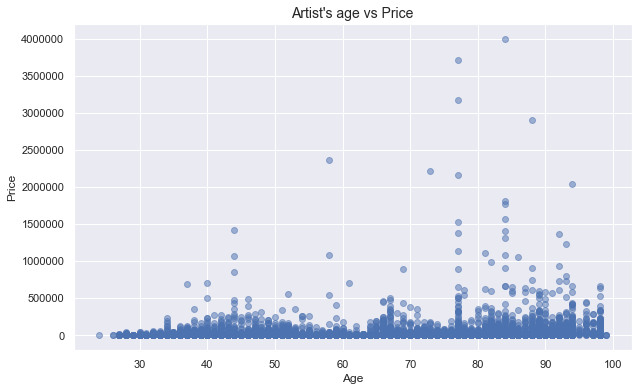

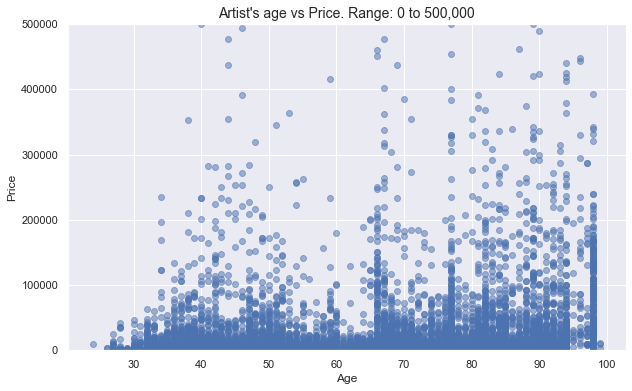

In [5]:
# Draw Scatter Plot:
price = saffronart_df.winning_bid 
age = saffronart_df.auction_dt_age # the artist's age at the time of the auction

def scatter_age_price(age, price, ylim=None):
    plt.figure(figsize=(10, 6))
    plt.scatter(age, price, alpha=0.5)
    plt.ylim(ylim)
    
    plt.xlabel('Age', fontsize=12)
    plt.ylabel('Price', fontsize=12)
    
    try:
        plt.title("Artist's age vs Price. Range: {:,} to {:,}".format(ylim[0], ylim[1]), fontsize=14)
    except TypeError: # if ylim is not given
        plt.title("Artist's age vs Price", fontsize=14)
    
scatter_age_price(age, price)
scatter_age_price(age, price, ylim=(0, 500000))

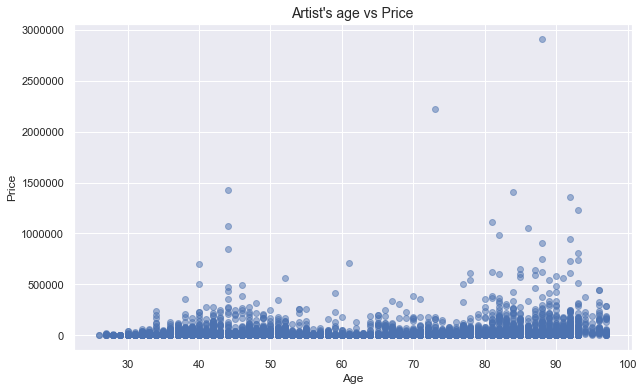

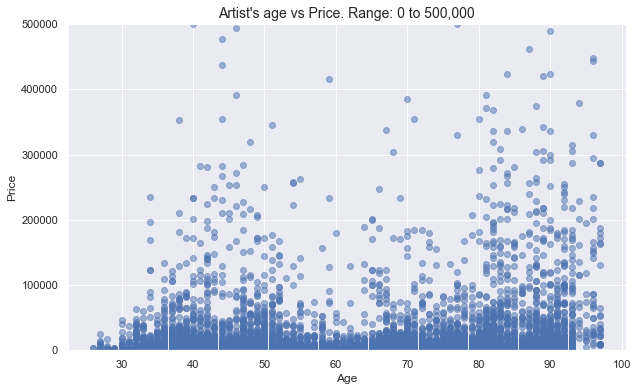

In [11]:
alive = saffronart_df.loc[saffronart_df.auction_dt_age < saffronart_df.artist_age]

alive_price = alive.winning_bid
alive_age = alive.auction_dt_age

scatter_age_price(alive_age, alive_price)
scatter_age_price(alive_age, alive_price, ylim=(0, 500000))